In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt  # one of the best graphics library for python

In [3]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

In [5]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            # ReLU activation
            nn.ReLU(inplace=True),
            # Max pool 2-d
            nn.MaxPool2d(kernel_size=2),
            
            # Second convolution layer
            # input size = (14, 14), output size = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # output size = (5, 5)
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weights in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # second fully connected layer
            # in_features = output of last linear layer = 120 
            nn.Linear(in_features=120, out_features=84), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # Third fully connected layer. It is also the output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weights_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x

In [6]:
lenet5_model = LeNet5()
print(lenet5_model)

LeNet5(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [8]:
def get_data(batch_size, data_root='data', num_workers=1):
    
    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scales image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.1307) and divide by variance (0.3081).
        # This mean and variance is calculated on training data (verify yourself)
        transforms.Normalize((0.1307, ), (0.3081, ))
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

In [9]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [10]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 20  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.01  # determines the speed of network's weights update
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "data"  # folder to save MNIST data (default: data/mnist-data)
    num_workers: int = 10  # number of concurrent processes used to prepare data
    device: str = 'cuda'  # device to use for training.
    


In [11]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [12]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mode
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (it is mandatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

In [13]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

In [14]:
def main(system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 5

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    # initiate model
    model = LeNet5()
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [15]:
model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main()

0it [00:00, ?it/s]

 99%|█████████▉| 9838592/9912422 [00:13<00:00, 714776.70it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]
 57%|█████▋    | 16384/28881 [00:00<00:00, 70752.41it/s]
32768it [00:00, 41017.59it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



 74%|███████▍  | 1220608/1648877 [00:01<00:01, 301002.50it/s]
1654784it [00:01, 841882.31it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 13831.92it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
Train Epoch: 0 [3200/60000] Loss: 2.261759 Acc: 0.3438
Train Epoch: 0 [6400/60000] Loss: 2.066856 Acc: 0.4062
Train Epoch: 0 [9600/60000] Loss: 0.725591 Acc: 0.8125
Train Epoch: 0 [12800/60000] Loss: 0.441980 Acc: 0.8750
Train Epoch: 0 [16000/60000] Loss: 0.788893 Acc: 0.7500
Train Epoch: 0 [19200/60000] Loss: 0.257747 Acc: 0.9375
Train Epoch: 0 [22400/60000] Loss: 0.441675 Acc: 0.9062
Train Epoch: 0 [25600/60000] Loss: 0.234152 Acc: 0.8750
Train Epoch: 0 [28800/60000] Loss: 0.176411 Acc: 0.9688
Train Epoch: 0 [32000/60000] Loss: 0.114743 Acc: 0.9375
Train Epoch: 0 [35200/60000] Loss: 0.186722 Acc: 0.9062
Train Epoch: 0 [38400/60000] Loss: 0.127582 Acc: 0.9688
Train Epoch: 0 [41600/60000] Loss: 0.130673 Acc: 0.9375
Train Epoch: 0 [44800/60000] Loss: 0.471457 Acc: 0.8750
Train Epoch: 0 [48000/60000] Loss: 0.085017 Acc: 1.0000
Train Epoch: 0 [51200/60000] Loss: 0.450019 Acc: 0.9062
Train Epoch: 0 [5

9920512it [00:30, 714776.70it/s]                             

Train Epoch: 2 [16000/60000] Loss: 0.040243 Acc: 1.0000
Train Epoch: 2 [19200/60000] Loss: 0.047129 Acc: 0.9688
Train Epoch: 2 [22400/60000] Loss: 0.025572 Acc: 1.0000
Train Epoch: 2 [25600/60000] Loss: 0.080974 Acc: 1.0000
Train Epoch: 2 [28800/60000] Loss: 0.169322 Acc: 0.9375
Train Epoch: 2 [32000/60000] Loss: 0.104314 Acc: 0.9375
Train Epoch: 2 [35200/60000] Loss: 0.042174 Acc: 0.9688
Train Epoch: 2 [38400/60000] Loss: 0.086843 Acc: 0.9688
Train Epoch: 2 [41600/60000] Loss: 0.199972 Acc: 0.9375
Train Epoch: 2 [44800/60000] Loss: 0.002991 Acc: 1.0000
Train Epoch: 2 [48000/60000] Loss: 0.076802 Acc: 0.9375
Train Epoch: 2 [51200/60000] Loss: 0.060964 Acc: 0.9688
Train Epoch: 2 [54400/60000] Loss: 0.039092 Acc: 0.9688
Train Epoch: 2 [57600/60000] Loss: 0.040171 Acc: 0.9688
Elapsed 12.98s, 4.33 s/epoch, 0.00 s/batch, ets 73.56s

Test set: Average loss: 0.0841, Accuracy: 9730/10000 (97%)

Train Epoch: 3 [3200/60000] Loss: 0.093556 Acc: 0.9375
Train Epoch: 3 [6400/60000] Loss: 0.289582 Ac

Train Epoch: 9 [41600/60000] Loss: 0.001320 Acc: 1.0000
Train Epoch: 9 [44800/60000] Loss: 0.007883 Acc: 1.0000
Train Epoch: 9 [48000/60000] Loss: 0.026004 Acc: 1.0000
Train Epoch: 9 [51200/60000] Loss: 0.136777 Acc: 0.9688
Train Epoch: 9 [54400/60000] Loss: 0.010332 Acc: 1.0000
Train Epoch: 9 [57600/60000] Loss: 0.001394 Acc: 1.0000
Elapsed 44.72s, 4.47 s/epoch, 0.00 s/batch, ets 44.72s

Test set: Average loss: 0.0382, Accuracy: 9876/10000 (98%)

Train Epoch: 10 [3200/60000] Loss: 0.038420 Acc: 0.9688
Train Epoch: 10 [6400/60000] Loss: 0.000675 Acc: 1.0000
Train Epoch: 10 [9600/60000] Loss: 0.005341 Acc: 1.0000
Train Epoch: 10 [12800/60000] Loss: 0.003622 Acc: 1.0000
Train Epoch: 10 [16000/60000] Loss: 0.011716 Acc: 1.0000
Train Epoch: 10 [19200/60000] Loss: 0.007628 Acc: 1.0000
Train Epoch: 10 [22400/60000] Loss: 0.000935 Acc: 1.0000
Train Epoch: 10 [25600/60000] Loss: 0.012051 Acc: 1.0000
Train Epoch: 10 [28800/60000] Loss: 0.008273 Acc: 1.0000
Train Epoch: 10 [32000/60000] Loss: 0.

Train Epoch: 16 [57600/60000] Loss: 0.000194 Acc: 1.0000
Elapsed 76.48s, 4.50 s/epoch, 0.00 s/batch, ets 13.50s

Test set: Average loss: 0.0422, Accuracy: 9871/10000 (98%)

Train Epoch: 17 [3200/60000] Loss: 0.011927 Acc: 1.0000
Train Epoch: 17 [6400/60000] Loss: 0.000341 Acc: 1.0000
Train Epoch: 17 [9600/60000] Loss: 0.001962 Acc: 1.0000
Train Epoch: 17 [12800/60000] Loss: 0.152615 Acc: 0.9688
Train Epoch: 17 [16000/60000] Loss: 0.000459 Acc: 1.0000
Train Epoch: 17 [19200/60000] Loss: 0.010600 Acc: 1.0000
Train Epoch: 17 [22400/60000] Loss: 0.000912 Acc: 1.0000
Train Epoch: 17 [25600/60000] Loss: 0.007516 Acc: 1.0000
Train Epoch: 17 [28800/60000] Loss: 0.016035 Acc: 1.0000
Train Epoch: 17 [32000/60000] Loss: 0.029722 Acc: 0.9688
Train Epoch: 17 [35200/60000] Loss: 0.001101 Acc: 1.0000
Train Epoch: 17 [38400/60000] Loss: 0.000614 Acc: 1.0000
Train Epoch: 17 [41600/60000] Loss: 0.001420 Acc: 1.0000
Train Epoch: 17 [44800/60000] Loss: 0.001499 Acc: 1.0000
Train Epoch: 17 [48000/60000] Lo

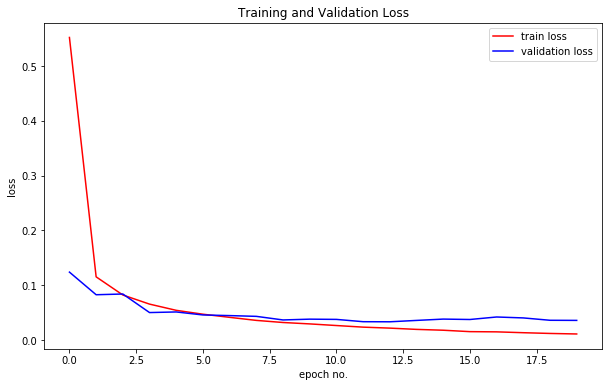

In [16]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_loss, color='r', label="train loss")
plt.plot(x, epoch_test_loss, color='b', label="validation loss")
plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

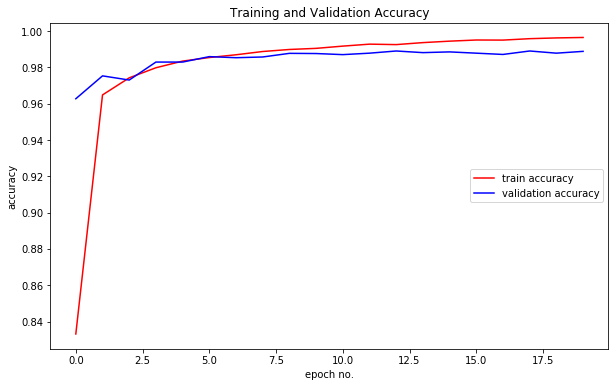

In [15]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_acc, color='r', label="train accuracy")
plt.plot(x, epoch_test_acc, color='b', label="validation accuracy")
plt.xlabel('epoch no.')
plt.ylabel('accuracy')
plt.legend(loc='center right')
plt.title('Training and Validation Accuracy')
plt.show()

In [16]:
models = 'models'
if not os.path.exists(models):
    os.makedirs(models)
    
model_file_name = 'lenet5_mnist.pt'

model_path = os.path.join(models, model_file_name)

# make sure you transfer the model to cpu.
model.to('cpu')

# save the state_dict
torch.save(model.state_dict(), model_path)

In [17]:
# initialize the model
lenet5_mnist = LeNet5()

# loading the model and getting model parameters by using load_state_dict
lenet5_mnist.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [18]:
def prediction(model, train_config, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(train_config.device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(train_config.device)

    output = model(data)

    # get probability score using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

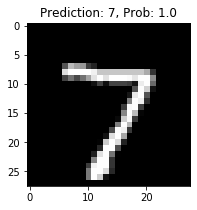

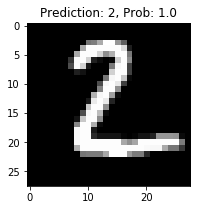

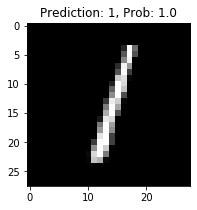

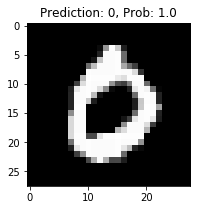

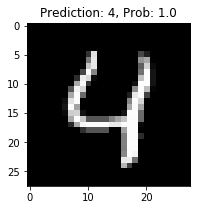

In [19]:
batch_size = 5
train_config = TrainingConfiguration()

if torch.cuda.is_available():
    train_config.device = "cuda"
else:
    train_config.device = "cpu"

# load test data without image transformation
test = torch.utils.data.DataLoader(
    datasets.MNIST(root=train_config.data_root, train=False, download=True, 
                   transform=transforms.functional.to_tensor),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

# load testdata with image transformation
image_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
    ])

test_trans = torch.utils.data.DataLoader(
    datasets.MNIST(root=train_config.data_root, train=False, download=True, transform=image_transforms),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

for data, _ in test_trans:
    # pass the loaded model
    pred, prob = prediction(lenet5_mnist, train_config, data)
    break
    

plt.rcParams["figure.figsize"] = (3, 3)
for images, _ in test:
    for i, img in enumerate(images):
        img = transforms.functional.to_pil_image(img)
        plt.imshow(img, cmap='gray')
        plt.gca().set_title('Prediction: {0}, Prob: {1:.2}'.format(pred[i], prob[i]))
        plt.show()
    break